# Ensemble classifier patient
 

In [1]:
# LIBRARIES

import pandas as pd
import numpy as np
import io
import statistics as stat
from sklearn import metrics
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf


#  warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Confidence intervals
from sklearn.metrics import roc_auc_score
from math import sqrt

def roc_auc_ci(AUC, y_true, positive=1):
    N1 = sum(y_true == positive)
    N2 = sum(y_true != positive)
    Q1 = AUC / (2 - AUC)
    Q2 = 2*AUC**2 / (1 + AUC)
    SE_AUC = sqrt((AUC*(1 - AUC) + (N1 - 1)*(Q1 - AUC**2) + (N2 - 1)*(Q2 - AUC**2)) / (N1*N2))
    lower = AUC - 1.96*SE_AUC
    upper = AUC + 1.96*SE_AUC
    if lower < 0:
        lower = 0
    if upper > 1:
        upper = 1
    return (lower, upper)

In [3]:
def roc_curve(y, X, range):

    fpr = []
    tpr = []

    for threshold in range:

        Predic = np.where(X < threshold, 0, 1)
        y_ensamble = np.where((Predic[:, 0] + Predic[:, 1] + Predic[:, 2]+ Predic[:, 3] + Predic[:, 4])>=3, 1, 0) 

        fp = np.sum((y_ensamble == 1) & (y == 0))
        tp = np.sum((y_ensamble == 1) & (y == 1))

        fn = np.sum((y_ensamble == 0) & (y == 1))
        tn = np.sum((y_ensamble == 0) & (y == 0))

        fpr.append((fp / (fp + tn)))
        tpr.append((tp / (tp + fn)))

    return [fpr, tpr]

In [4]:
# file upload 
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
end2end = pd.read_csv('/content/drive/MyDrive/COLAB/end2end.csv')
frcnn = pd.read_csv('/content/drive/MyDrive/COLAB/frcnn.csv')
glam = pd.read_csv('/content/drive/MyDrive/COLAB/glamn.csv')
gmic = pd.read_csv('/content/drive/MyDrive/COLAB/gmicn.csv')
nyu_single = pd.read_csv('/content/drive/MyDrive/COLAB/nyu_single.csv')
# the gmicn and glamn files are loaded because they have the same order in the predictions as the other models 

Mounted at /content/drive


In [5]:
# Data information 
print("Images number")
print(len(glam['malignant_label']))
print("Patients number ")
print(len(glam['malignant_label'])/4)
print("Number of cancer patients ")
print(len(glam['malignant_label'])/8)
print("number of patients without cancer ")
print(len(glam['malignant_label'])/8)

Images number
1528
Patients number 
382.0
Number of cancer patients 
191.0
number of patients without cancer 
191.0


In [6]:
# Labels 
y_labels = glam['malignant_label'] 
# The model predictions are concatenated in X_predic
X_predic = pd.concat([end2end.loc[:, ['malignant_pred']], frcnn.loc[:, ['malignant_pred']], glam.loc[:, ['malignant_pred']], gmic.loc[:, ['malignant_pred']], nyu_single.loc[:, ['malignant_pred']]], axis=1)
# Each column is named according to the model
X_predic.columns = ['mal_pred_end2end', 'mal_pred_frcnn', 'mal_pred_glam', 'mal_pred_gmic', 'mal_pred_nyu_single']

In [7]:
# prediction calculation by patient
Y = y_labels.to_numpy()
X = X_predic.to_numpy()
Xp = np.zeros((382, 5))
Yp = np.zeros((382, 1))
np.array(Y, dtype=bool)

for i in  range(382):
     Xp[i,:] =  (X[4*i,:]+X[4*i+1,:]+X[4*i+2,:]+X[4*i+3,:])/4
     Yp[i] = ( Y[4*i] or Y[4*i+1] or Y[4*i+2] or Y[4*i+3] ) 

X_predic_p = pd.DataFrame(Xp, columns = ['mal_pred_end2end', 'mal_pred_frcnn', 'mal_pred_glam', 'mal_pred_gmic', 'mal_pred_nyu_single'])
y_labels_p = pd.Series(np.squeeze(Yp))

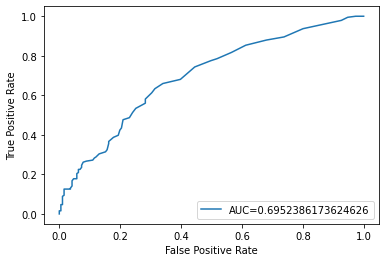

(0.6427877450890929, 0.7476894896358324)

In [9]:
[fpr, tpr] = roc_curve(y_labels_p, X_predic_p, np.arange(0, 1, 0.001))

#create ROC curve
auc = metrics.auc(fpr, tpr)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()
roc_auc_ci(auc, y_labels_p)